#                                                     __Crime Classification Model using Pyspark__
<ol>
  <li>Muhammad Sheroz 9852</li>
  <li>Kehkashan Akram 9825</li>
  <li>Hassan Noor Soomro 9827</li>
</ol> 

In [3]:
import pyspark
spark = pyspark.sql.SparkSession.builder.appName("clipper-pyspark").getOrCreate()

sc = spark.sparkContext

e:\Course\BigData\Project\projectenv\lib\site-packages\pyspark\context.py:238: FutureWarning: Python 3.6 support is deprecated in Spark 3.2.
  FutureWarning


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
np.random.seed(60)

## __3. Data Extraction__

In [13]:
#Read the data into spark datafrome
from pyspark.sql.functions import col, lower
df = spark.read.format('csv')\
          .option('header','true')\
          .option('inferSchema', 'true')\
          .option('timestamp', 'true')\
          .load('./Data2/train/train.csv')

data = df.select(lower(col('Category')),lower(col('Descript')))\
        .withColumnRenamed('lower(Category)','Category')\
        .withColumnRenamed('lower(Descript)', 'Description')
data.cache()
print('Dataframe Structure')
print('----------------------------------')
print(data.printSchema())
print(' ')
print('Dataframe preview')
print(data.show(5))
print(' ')
print('----------------------------------')
print('Total number of rows', df.count())

Dataframe Structure
----------------------------------
root
 |-- Category: string (nullable = true)
 |-- Description: string (nullable = true)

None
 
Dataframe preview
+--------------+--------------------+
|      Category|         Description|
+--------------+--------------------+
|      warrants|      warrant arrest|
|other offenses|traffic violation...|
|other offenses|traffic violation...|
| larceny/theft|grand theft from ...|
| larceny/theft|grand theft from ...|
+--------------+--------------------+
only showing top 5 rows

None
 
----------------------------------
Total number of rows 878049


**Explanation**: __To familiar ourselves with the dataset, we need to see the top list of the crime categories and descriptions__.

In [14]:
def top_n_list(df,var, N):
    '''
    This function determine the top N numbers of the list
    '''
    print("Total number of unique value of"+' '+var+''+':'+' '+str(df.select(var).distinct().count()))
    print(' ')
    print('Top'+' '+str(N)+' '+'Crime'+' '+var)
    df.groupBy(var).count().withColumnRenamed('count','totalValue')\
    .orderBy(col('totalValue').desc()).show(N)
    
    
top_n_list(data, 'Category',10)
print(' ')
print(' ')
top_n_list(data,'Description',10)

Total number of unique value of Category: 39
 
Top 10 Crime Category
+--------------+----------+
|      Category|totalValue|
+--------------+----------+
| larceny/theft|    174900|
|other offenses|    126182|
|  non-criminal|     92304|
|       assault|     76876|
| drug/narcotic|     53971|
| vehicle theft|     53781|
|     vandalism|     44725|
|      warrants|     42214|
|      burglary|     36755|
|suspicious occ|     31414|
+--------------+----------+
only showing top 10 rows

 
 
Total number of unique value of Description: 879
 
Top 10 Crime Description
+--------------------+----------+
|         Description|totalValue|
+--------------------+----------+
|grand theft from ...|     60022|
|       lost property|     31729|
|             battery|     27441|
|   stolen automobile|     26897|
|drivers license, ...|     26839|
|      warrant arrest|     23754|
|suspicious occurr...|     21891|
|aided case, menta...|     21497|
|petty theft from ...|     19771|
|malicious mischie...|   

**Explanation**: __Category feature will be our label (multi-class). How many classes?__

In [15]:
data.select('Category').distinct().count()

39

## __4. Partition the dataset into Training and Test dataset__

In [16]:
training, test = data.randomSplit([0.7,0.3], seed=60)
#trainingSet.cache()
print("Training Dataset Count:", training.count())
print("Test Dataset Count:", test.count())

Training Dataset Count: 614184
Test Dataset Count: 263865


## __5. Define Structure to build Pipeline__
__The process of cleaning the dataset involves:__  
* __Define tokenization function using RegexTokenizer__: RegexTokenizer allows more advanced tokenization based on regular expression (regex) matching. By default, the parameter “pattern” (regex, default: “\s+”) is used as delimiters to split the input text. Alternatively, users can set parameter “gaps” to false indicating the regex “pattern” denotes “tokens” rather than splitting gaps, and find all matching occurrences as the tokenization result.  

* __Define stop remover function using StopWordsRemover__: StopWordsRemover takes as input a sequence of strings (e.g. the output of a Tokenizer) and drops all the stop words from the input sequences. The list of stopwords is specified by the stopWords parameter.  

* __Define bag of words function for Descript variable using CountVectorizer__: CountVectorizer can be used as an estimator to extract the vocabulary, and generates a CountVectorizerModel. The model produces sparse representations for the documents over the vocabulary, which can then be passed to other algorithms like LDA. During the fitting process, CountVectorizer will select the top vocabSize words ordered by term frequency across the corpus. An optional parameter minDF also affects the fitting process by specifying the minimum number (or fraction if < 1.0) of documents a term must appear in to be included in the vocabulary.  

* __Define function to Encode the values of category variable using StringIndexer__: StringIndexer encodes a string column of labels to a column of label indices. The indices are in (0, numLabels), ordered by label frequencies, so the most frequent label gets index 0. In our case, the label colum(Category) will be encoded to label indices, from 0 to 38; the most frequent label (LARCENY/THEFT) will be indexed as 0.

* __Define a pipeline to call these functions__: ML Pipelines provide a uniform set of high-level APIs built on top of DataFrames that help users create and tune practical machine learning pipelines.        

In [18]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, OneHotEncoder, StringIndexer, VectorAssembler, HashingTF, IDF, Word2Vec
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, NaiveBayes 

#----------------Define tokenizer with regextokenizer()------------------
regex_tokenizer = RegexTokenizer(pattern='\\W')\
                  .setInputCol("Description")\
                  .setOutputCol("tokens")

#----------------Define stopwords with stopwordsremover()---------------------
extra_stopwords = ['http','amp','rt','t','c','the']
stopwords_remover = StopWordsRemover()\
                    .setInputCol('tokens')\
                    .setOutputCol('filtered_words')\
                    .setStopWords(extra_stopwords)
                    

#----------Define bags of words using countVectorizer()---------------------------
count_vectors = CountVectorizer(vocabSize=10000, minDF=5)\
               .setInputCol("filtered_words")\
               .setOutputCol("features")


#-----------Using TF-IDF to vectorise features instead of countVectoriser-----------------
hashingTf = HashingTF(numFeatures=10000)\
            .setInputCol("filtered_words")\
            .setOutputCol("raw_features")
            
#Use minDocFreq to remove sparse terms
idf = IDF(minDocFreq=5)\
        .setInputCol("raw_features")\
        .setOutputCol("features")

#---------------Define bag of words using Word2Vec---------------------------
word2Vec = Word2Vec(vectorSize=1000, minCount=0)\
           .setInputCol("filtered_words")\
           .setOutputCol("features")

#-----------Encode the Category variable into label using StringIndexer-----------
label_string_idx = StringIndexer()\
                  .setInputCol("Category")\
                  .setOutputCol("label")

#-----------Define classifier structure for logistic Regression--------------
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)

#---------Define classifier structure for Naive Bayes----------
nb = NaiveBayes(smoothing=1)

def metrics_ev(labels, metrics):
    '''
    List of all performance metrics
    '''
    # Confusion matrix
    print("---------Confusion matrix-----------------")
    print(metrics.confusionMatrix)
    print(' ')    
    # Overall statistics
    print('----------Overall statistics-----------')
    print("Precision = %s" %  metrics.precision())
    print("Recall = %s" %  metrics.recall())
    print("F1 Score = %s" % metrics.fMeasure())
    print(' ')
    # Statistics by class
    print('----------Statistics by class----------')
    for label in sorted(labels):
       print("Class %s precision = %s" % (label, metrics.precision(label)))
       print("Class %s recall = %s" % (label, metrics.recall(label)))
       print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label, beta=1.0)))
    print(' ')
    # Weighted stats
    print('----------Weighted stats----------------')
    print("Weighted recall = %s" % metrics.weightedRecall)
    print("Weighted precision = %s" % metrics.weightedPrecision)
    print("Weighted F(1) Score = %s" % metrics.weightedFMeasure())
    print("Weighted F(0.5) Score = %s" % metrics.weightedFMeasure(beta=0.5))
    print("Weighted false positive rate = %s" % metrics.weightedFalsePositiveRate)
    

## __6. Build Multi-Classification__
__The stages involve to perform multi-classification include:__
1. Model training and evaluation
   1. Build baseling model
      1. Logistic regression using CountVectorizer features
   2. Build secondary models
      1. Naive Bayes
      2. Logistic regression and Naive Bayes using TF-IDF features
      3. Logistic regression and Naive Bayes using word2Vec
    
 ### __(i) Baseline Model__ 
Baseline model should be quick, low cost and simple to setup and produce a decent results. One of the reason to consider baselines because they iterate very quickly, while wasting minimal time. To further undertand why and how to apply baselines, please refer to Emmanuel Ameisen's article: [Always start with a stupid model, no exceptions.](https://blog.insightdatascience.com/always-start-with-a-stupid-model-no-exceptions-3a22314b9aaa)

#### __(a). Apply Logistic Regression with  Count Vector Features__
We will build a model to make predictions and score on the test sets using logistics regression using the dataset we transformed using count vectors. And we will see the top 10 predictions from the highest probability from our model, accuracy and other metrics to evaluate our model.  

Note: Fit regex_tokenizer,stopwords_remover,count_vectors,label_string_idx, and lr functions into pipeline.  

In [19]:
pipeline_cv_lr = Pipeline().setStages([regex_tokenizer,stopwords_remover,count_vectors,label_string_idx, lr])
model_cv_lr = pipeline_cv_lr.fit(training)
predictions_cv_lr = model_cv_lr.transform(test)

In [20]:
print('-----------------------------Check Top 5 predictions----------------------------------')
print(' ')
predictions_cv_lr.select('Description','Category',"probability","label","prediction")\
                                        .orderBy("probability", ascending=False)\
                                        .show(n=5, truncate=30)

-----------------------------Check Top 5 predictions----------------------------------
 
+------------------------------+-------------+------------------------------+-----+----------+
|                   Description|     Category|                   probability|label|prediction|
+------------------------------+-------------+------------------------------+-----+----------+
|theft, bicycle, <$50, no se...|larceny/theft|[0.8749423696807065,0.02006...|  0.0|       0.0|
|theft, bicycle, <$50, no se...|larceny/theft|[0.8749423696807065,0.02006...|  0.0|       0.0|
|theft, bicycle, <$50, no se...|larceny/theft|[0.8749423696807065,0.02006...|  0.0|       0.0|
|theft, bicycle, <$50, no se...|larceny/theft|[0.8749423696807065,0.02006...|  0.0|       0.0|
|theft, bicycle, <$50, no se...|larceny/theft|[0.8749423696807065,0.02006...|  0.0|       0.0|
+------------------------------+-------------+------------------------------+-----+----------+
only showing top 5 rows



In [21]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator 
evaluator_cv_lr = MulticlassClassificationEvaluator().setPredictionCol("prediction").evaluate(predictions_cv_lr)
print(' ')
print('------------------------------Accuracy----------------------------------')
print(' ')
print('                       accuracy:{}:'.format(evaluator_cv_lr))

 
------------------------------Accuracy----------------------------------
 
                       accuracy:0.9720978704608143:


 ### __(ii). Secondary Models__
 #### __(a). Apply Naive Bayes with Count Vector Features__
Naive Bayes classifiers are a family of simple probabilistic classifiers based on applying Bayes’ theorem with strong (naive) independence assumptions between the features. The spark.ml implementation currently supports both multinomial naive Bayes and Bernoulli naive Bayes.   

 Fit regex_tokenizer,stopwords_remover,count_vectors,label_string_idx, and nb functions into pipeline.

In [22]:
### Secondary model using NaiveBayes
pipeline_cv_nb = Pipeline().setStages([regex_tokenizer,stopwords_remover,count_vectors,label_string_idx, nb])
model_cv_nb = pipeline_cv_nb.fit(training)
predictions_cv_nb = model_cv_nb.transform(test)

In [23]:
evaluator_cv_nb = MulticlassClassificationEvaluator().setPredictionCol("prediction").evaluate(predictions_cv_nb)
print(' ')
print('--------------------------Accuracy-----------------------------')
print(' ')
print('                      accuracy:{}:'.format(evaluator_cv_nb))

 
--------------------------Accuracy-----------------------------
 
                      accuracy:0.9934759321636689:


#### __(b). Apply Logistic Regression Using TF-IDF Features__ 
Term frequency-inverse document frequency (TF-IDF) is a feature vectorization method widely used in text mining to reflect the importance of a term to a document in the corpus. Denote a term by t, a document by _d_, and the corpus by _D_. Term frequency TF(t,d) is the number of times that term t appears in document _d_, while document frequency _DF(t,D)_ is the number of documents that contains term _t_. If we only use term frequency to measure the importance, it is very easy to over-emphasize terms that appear very often but carry little information about the document, e.g. “a”, “the”, and “of”. If a term appears very often across the corpus, it means it doesn’t carry special information about a particular document. Inverse document frequency is a numerical measure of how much information a term provides:   $$IDF(t,D) = log {|D|+1DF \over (t,D)+1} $$, where |D| is the total number of documents in the corpus. Since logarithm is used, if a term appears in all documents, its IDF value becomes 0. Note that a smoothing term is applied to avoid dividing by zero for terms outside the corpus. The TF-IDF measure is simply the product of TF and IDF:
$$TFIDF(t,d,D) = {TF(t,d)⋅IDF(t,D)} $$.  

There are several variants on the definition of term frequency and document frequency. In MLlib, we separate TF and IDF to make them flexible.  

Note: Fit regex_tokenizer, stopwords_remover,hashingTF, idf,label_string_idx, and nb functions into pipeline.

In [24]:
pipeline_idf_lr = Pipeline().setStages([regex_tokenizer,stopwords_remover,hashingTf, idf, label_string_idx, lr])
model_idf_lr = pipeline_idf_lr.fit(training)
predictions_idf_lr = model_idf_lr.transform(test)

In [25]:
print('-----------------------------Check Top 5 predictions----------------------------------')
print(' ')
predictions_idf_lr.select('Description','Category',"probability","label","prediction")\
                                        .orderBy("probability", ascending=False)\
                                        .show(n=5, truncate=30)

-----------------------------Check Top 5 predictions----------------------------------
 
+------------------------------+-------------+------------------------------+-----+----------+
|                   Description|     Category|                   probability|label|prediction|
+------------------------------+-------------+------------------------------+-----+----------+
|theft, bicycle, <$50, no se...|larceny/theft|[0.8862018715515749,0.01828...|  0.0|       0.0|
|theft, bicycle, <$50, no se...|larceny/theft|[0.8862018715515749,0.01828...|  0.0|       0.0|
|theft, bicycle, <$50, no se...|larceny/theft|[0.8862018715515749,0.01828...|  0.0|       0.0|
|theft, bicycle, <$50, no se...|larceny/theft|[0.8862018715515749,0.01828...|  0.0|       0.0|
|theft, bicycle, <$50, no se...|larceny/theft|[0.8862018715515749,0.01828...|  0.0|       0.0|
+------------------------------+-------------+------------------------------+-----+----------+
only showing top 5 rows



In [26]:
evaluator_idf_lr = MulticlassClassificationEvaluator().setPredictionCol("prediction").evaluate(predictions_idf_lr)
print(' ')
print('-------------------------------Accuracy---------------------------------')
print(' ')
print('                        accuracy:{}:'.format(evaluator_idf_lr))

 
-------------------------------Accuracy---------------------------------
 
                        accuracy:0.9723250448741841:


#### __(c). Apply Naive Bayes with TF-IDF Features__

In [27]:
pipeline_idf_nb = Pipeline().setStages([regex_tokenizer,stopwords_remover,hashingTf, idf, label_string_idx, nb])
model_idf_nb = pipeline_idf_nb.fit(training)
predictions_idf_nb = model_idf_nb.transform(test)

In [28]:
evaluator_idf_nb = MulticlassClassificationEvaluator().setPredictionCol("prediction").evaluate(predictions_idf_nb)
print(' ')
print('-----------------------------Accuracy-----------------------------')
print(' ')
print('                          accuracy:{}:'.format(evaluator_idf_nb))

 
-----------------------------Accuracy-----------------------------
 
                          accuracy:0.9949800808644228:


#### __(e). Apply Logistic Regression Using Word2Vec features__ 
Word2Vec is an Estimator which takes sequences of words representing documents and trains a Word2VecModel. The model maps each word to a unique fixed-size vector. The Word2VecModel transforms each document into a vector using the average of all words in the document; this vector can then be used as features for prediction, document similarity calculations, etc. 

In [29]:
pipeline_wv_lr = Pipeline().setStages([regex_tokenizer,stopwords_remover, word2Vec, label_string_idx, lr])
model_wv_lr = pipeline_wv_lr.fit(training)
predictions_wv_lr = model_wv_lr.transform(test)

Py4JJavaError: An error occurred while calling o152.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 3 in stage 186.0 failed 1 times, most recent failure: Lost task 3.0 in stage 186.0 (TID 1204) (LAPTOP-40O6BNM4 executor driver): java.lang.OutOfMemoryError: Java heap space
	at scala.reflect.ManifestFactory$DoubleManifest.newArray(Manifest.scala:194)
	at scala.reflect.ManifestFactory$DoubleManifest.newArray(Manifest.scala:191)
	at scala.Array$.ofDim(Array.scala:305)
	at org.apache.spark.ml.linalg.Matrices$.fromVectors(Matrices.scala:1017)
	at org.apache.spark.ml.feature.InstanceBlock$.fromInstances(Instance.scala:138)
	at org.apache.spark.ml.feature.InstanceBlock$$anon$1.next(Instance.scala:177)
	at org.apache.spark.ml.feature.InstanceBlock$$anon$1.next(Instance.scala:151)
	at org.apache.spark.storage.memory.PartiallyUnrolledIterator.next(MemoryStore.scala:783)
	at org.apache.spark.serializer.SerializationStream.writeAll(Serializer.scala:140)
	at org.apache.spark.serializer.SerializerManager.dataSerializeStream(SerializerManager.scala:177)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$3(BlockManager.scala:1490)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$3$adapted(BlockManager.scala:1488)
	at org.apache.spark.storage.BlockManager$$Lambda$5120/174619215.apply(Unknown Source)
	at org.apache.spark.storage.DiskStore.put(DiskStore.scala:70)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1488)
	at org.apache.spark.storage.BlockManager$$Lambda$2043/412096492.apply(Unknown Source)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1408)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1472)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1295)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:384)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:335)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2454)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2403)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2402)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2402)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1160)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1160)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1160)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2642)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2584)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2573)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:938)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2214)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2309)
	at org.apache.spark.rdd.RDD.$anonfun$fold$1(RDD.scala:1183)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.fold(RDD.scala:1177)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$1(RDD.scala:1246)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1222)
	at org.apache.spark.ml.optim.loss.RDDLossFunction.calculate(RDDLossFunction.scala:61)
	at org.apache.spark.ml.optim.loss.RDDLossFunction.calculate(RDDLossFunction.scala:47)
	at breeze.optimize.CachedDiffFunction.calculate(CachedDiffFunction.scala:24)
	at breeze.optimize.FirstOrderMinimizer.calculateObjective(FirstOrderMinimizer.scala:50)
	at breeze.optimize.FirstOrderMinimizer.initialState(FirstOrderMinimizer.scala:44)
	at breeze.optimize.FirstOrderMinimizer.iterations(FirstOrderMinimizer.scala:96)
	at org.apache.spark.ml.classification.LogisticRegression.trainImpl(LogisticRegression.scala:999)
	at org.apache.spark.ml.classification.LogisticRegression.$anonfun$train$1(LogisticRegression.scala:628)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.classification.LogisticRegression.train(LogisticRegression.scala:495)
	at org.apache.spark.ml.classification.LogisticRegression.train(LogisticRegression.scala:286)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:151)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:745)
Caused by: java.lang.OutOfMemoryError: Java heap space
	at scala.reflect.ManifestFactory$DoubleManifest.newArray(Manifest.scala:194)
	at scala.reflect.ManifestFactory$DoubleManifest.newArray(Manifest.scala:191)
	at scala.Array$.ofDim(Array.scala:305)
	at org.apache.spark.ml.linalg.Matrices$.fromVectors(Matrices.scala:1017)
	at org.apache.spark.ml.feature.InstanceBlock$.fromInstances(Instance.scala:138)
	at org.apache.spark.ml.feature.InstanceBlock$$anon$1.next(Instance.scala:177)
	at org.apache.spark.ml.feature.InstanceBlock$$anon$1.next(Instance.scala:151)
	at org.apache.spark.storage.memory.PartiallyUnrolledIterator.next(MemoryStore.scala:783)
	at org.apache.spark.serializer.SerializationStream.writeAll(Serializer.scala:140)
	at org.apache.spark.serializer.SerializerManager.dataSerializeStream(SerializerManager.scala:177)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$3(BlockManager.scala:1490)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$3$adapted(BlockManager.scala:1488)
	at org.apache.spark.storage.BlockManager$$Lambda$5120/174619215.apply(Unknown Source)
	at org.apache.spark.storage.DiskStore.put(DiskStore.scala:70)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1488)
	at org.apache.spark.storage.BlockManager$$Lambda$2043/412096492.apply(Unknown Source)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1408)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1472)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1295)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:384)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:335)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)


In [ ]:
evaluator_wv_lr = MulticlassClassificationEvaluator().setPredictionCol("prediction").evaluate(predictions_wv_lr)
print('--------------------------Accuracy------------')
print(' ')
print('                  accuracy:{}:'.format(evaluator_wv_lr))

--------------------------Accuracy------------
 
                  accuracy:0.9073464410736654:


#### __(f). Apply Naive Bayes Using Word2Vec features__

In [ ]:
#pipeline_wv_nb = Pipeline().setStages([regex_tokenizer,stopwords_remover, word2Vec, label_string_idx, nb])
#model_wv_nb = pipeline_wv_nb.fit(training)
#predictions_wv_nb = model_wv_nb.transform(test)

In [ ]:
#evaluator_wv_nb = MulticlassClassificationEvaluator().setPredictionCol("prediction").evaluate(predictions_wv_nb)
#print('--------Accuracy------------')
#print(' ')
#print('accuracy:{}%:'.format(round(evaluator_wv_nb *100),2))

## 7. __Results:__
__The table below has accuracy of the models generated by different extraction techniques.__

|                    | Logistic Regression | Naive Bayes |
| -------------------|:-------------------:|------------:|
| Count Vectoriser   |  97.2%              |   99.3%     |
| TF-IDF             |  97.2%              |   99.5%     |
| Word2Vec           |  90.7%              |             |

**Explanation**: __As you can see, TF-IDF proves to be best vectoriser for this dataset, while Naive Bayes proves to be better algorithm for text analysis than Logistic regression.__

## __8. Deploy the Model__
We will use Flask. To know more about Flask, check [Full Stack Python.](https://www.fullstackpython.com/flask.html)

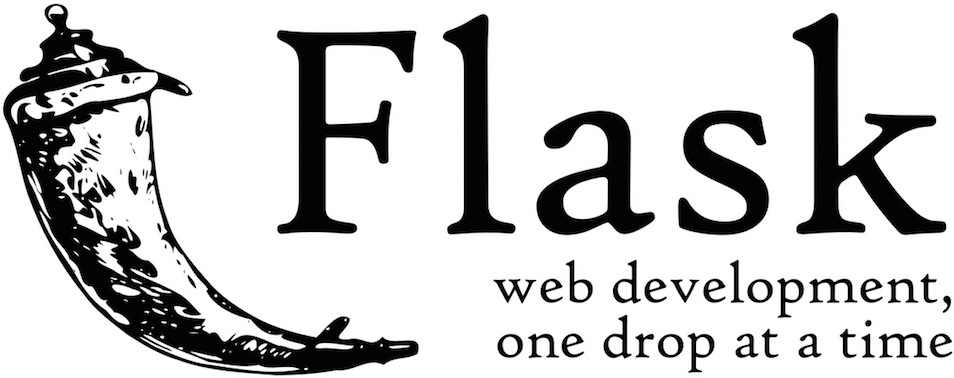

In [ ]:
Image('flask.jpg')

In [ ]:
from flask import Flask, request, jsonify
from pyspark.ml import PipelineModel

In [ ]:
app = Flask(__name__)

In [ ]:
# Load the Model
MODEL=pyspark.ml.PipelineModel("spark-naive-bayes-model")

In [ ]:
HTTP_BAD_REQUEST = 400

In [ ]:
@app.route('/predict')
def predict():
    Description = request.args.get('Description', default=None, type=str)
    
    # Reject request that have bad or missing values.
    if Description is None:
        # Provide the caller with feedback on why the record is unscorable.
        message = ('Record cannot be scored because of '
                   'missing or unacceptable values. '
                   'All values must be present and of type string.')
        response = jsonify(status='error',
                           error_message=message)
        # Sets the status code to 400
        response.status_code = HTTP_BAD_REQUEST
        return response
    
    features = [[Description]]
    predictions = MODEL.transform(features)
    label_pred = predictions.select("Description","Category","probability","prediction")
    return jsonify(status='complete', label=label_pred)

In [ ]:
if __name__ == '__main__':
    app.run(debug=True)

In [ ]:
import requests
#response = requests.get('http://127.0.0.1:5000/predict?Description=arson')
#response.text